## Загружаем нужные библиотеки:

In [197]:
from datetime import timedelta
import numpy as np              # Массивы (матрицы, векторы, линейная алгебра)
import os
import pandas as pd             # Таблицы и временные ряды (dataframe, series)
import sklearn                  # Алгоритмы машинного обучения
import sklearn.model_selection
import sklearn.metrics
import matplotlib.pyplot as plt  # Научная графика
%matplotlib inline
# Говорим jupyter'у, чтобы весь графический вывод был в браузере, а не в отдельном окне

from sklearn.neural_network import MLPClassifier

## Загружаем данные:

In [33]:
DATASET_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'healthcare-dataset-stroke-data.csv'))
dataset = pd.read_csv(DATASET_PATH)

dataset.columns = dataset.columns.str.strip()

dataset.drop('id', axis=1, inplace=True)
dataset['gender'] = np.where(dataset['gender'] == 'Female', 1, 0)
dataset['bmi'].replace({'N/A': None}, inplace=True)
dataset['bmi'].fillna(dataset['bmi'].median(), inplace=True)
dataset['smoking_status'].replace({'Unknown': None}, inplace=True)
probabilities = dataset['smoking_status'].value_counts(normalize=True)
missing = dataset['smoking_status'].isnull()
dataset.loc[missing, 'smoking_status'] = np.random.choice(probabilities.index, size=len(dataset[missing]), p=probabilities.values)
dataset['ever_married'] = np.where(dataset['ever_married'] == 'Yes', 1, 0)
dataset['Residence_type'] = np.where(dataset['Residence_type'] == 'Urban', 1, 0)
dataset = pd.get_dummies(dataset)
dataset_normalized = (dataset - dataset.mean(axis = 0)) / dataset.std(axis = 0)

## Разбиваем данные на обучающую и тестовую выборки:

При разбиении 30% данных отнесли к тестовой выборке, остальные 70% к обучающей.

In [147]:
x = dataset_normalized.drop(['stroke'], axis=1)
y = dataset['stroke']
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.30, random_state=40)

## Обучаем классификатор:

In [148]:
model = MLPClassifier(hidden_layer_sizes=(100,),
    solver='lbfgs',
    activation='logistic',
    random_state=42)

In [149]:
%%time
model.fit(x_train, y_train)

Wall time: 4.73 s


MLPClassifier(activation='logistic', random_state=42, solver='lbfgs')

## Проверяем качество классификатора:

In [150]:
y_train_prediction = model.predict(x_train)
y_test_prediction = model.predict(x_test)

In [151]:
print('Train: {}'.format(sklearn.metrics.accuracy_score(y_train, y_train_prediction)))

Train: 1.0


In [152]:
print('Test: {}'.format(sklearn.metrics.accuracy_score(y_test, y_test_prediction)))

Test: 0.923679060665362


## Подбор _гипер_параметров:

Подберем оптимальное значение параметра регуляризации $\alpha\$.

In [185]:
alpha_arr = np.logspace(-3, 2, 20)
test_err = []
train_err = []

for alpha in alpha_arr:
    model = MLPClassifier(
        alpha=alpha,
        hidden_layer_sizes=(100,),
        solver='lbfgs',
        activation ='logistic',
        max_iter=1000,
        random_state = 42
    )
    model.fit(x_train, y_train)

    y_train_prediction = model.predict(x_train)
    y_test_prediction = model.predict(x_test)

    test_err.append(np.mean(y_test != y_test_prediction))
    train_err.append(np.mean(y_train != y_train_prediction))

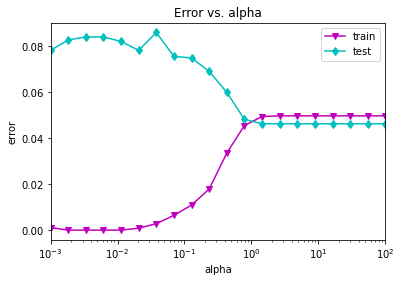

In [186]:
plt.semilogx(alpha_arr, train_err, 'm-v', label='train')
plt.semilogx(alpha_arr, test_err, 'c-d', label='test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

При значениях больших чем 1.0 практически не наблюдается изменение метрики.

In [187]:
min_test_err = np.min(test_err)
alpha_optimal = alpha_arr[test_err == min_test_err][0]
print('Optimal alpha: {}'.format(alpha_optimal))

Optimal alpha: 1.438449888287663


##  Подбор числа нейронов:

Оптимальное число нейронов будем искать при оптимальном альфа.

In [188]:
neuron_count_arr = np.linspace(1, 800, 27).astype(int)
test_err = []
train_err = []

for neuron_count in neuron_count_arr:
    model = MLPClassifier(alpha=alpha_optimal, hidden_layer_sizes=(neuron_count,), 
                          solver='lbfgs', activation ='logistic', max_iter=1000, random_state = 42)
    model.fit(x_train, y_train)

    y_train_prediction = model.predict(x_train)
    y_test_prediction = model.predict(x_test)

    test_err.append(np.mean(y_test != y_test_prediction))
    train_err.append(np.mean(y_train != y_train_prediction))

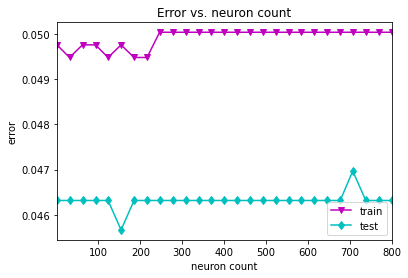

In [189]:
plt.plot(neuron_count_arr, train_err, 'm-v', label='train')
plt.plot(neuron_count_arr, test_err, 'c-d', label='test')
plt.xlim([np.min(neuron_count_arr), np.max(neuron_count_arr)])
plt.title('Error vs. neuron count')
plt.xlabel('neuron count')
plt.ylabel('error')
plt.legend()

In [190]:
min_test_err = np.min(test_err)
neuron_count_optimal = neuron_count_arr[test_err == min_test_err][0]
print('Optimal neuron count: {}'.format(neuron_count_optimal))

Optimal neuron count: 154


При значения больших чем 150 значение метрики практически не изменяется, имеющиеся колебания достаточно незначительны.

##  Итоговая классификация:

In [191]:
model = MLPClassifier(
    alpha=alpha_optimal,
    hidden_layer_sizes=(neuron_count_optimal,),
    solver='lbfgs',
    activation='logistic',
    max_iter=1000,
    random_state=42
)

model.fit(x_train, y_train)

y_train_prediction = model.predict(x_train)
y_test_prediction = model.predict(x_test)

print('[Accuracy on optimized]\n')
print('Train: {}, Test: {}'.format(
    sklearn.metrics.accuracy_score(y_train, y_train_prediction),
    sklearn.metrics.accuracy_score(y_test, y_test_prediction)
))



[Accuracy on optimized]

Train: 0.9502376292982947, Test: 0.954337899543379


## Матрица рассогласования:

In [192]:
from sklearn.metrics import plot_confusion_matrix

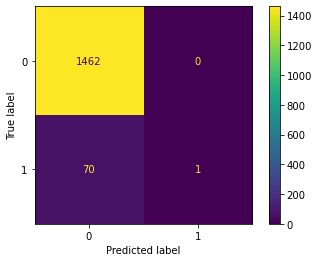

In [193]:
plot_confusion_matrix(model, x_test, y_test) 

##  Выводы:

- Изначально у тренировочной выборки метрика была равна 1. Наблюдалось переобучение, при устранении которого, видимо, и был получен лучший результат на тестовой выборке.
-Подбор оптимального числа нейронов при оптимальном значении регуляции помог немного повысить точность на тестовой выборке.